In [1]:
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import re
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB,GaussianNB
from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sagar\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### Exploratory Analysis

In [3]:
emails = pd.read_csv('emails.csv')

In [4]:
emails.sample(10)

,text,spam
4260,Subject: special epri mtg on ancillary service...,0
4883,Subject: re : action learning project and enro...,0
1694,Subject: thursday summer intern dinner vince ...,0
4376,"Subject: re : grades mr . kaminsky , i still...",0
1390,"Subject: visiting enron may 4 th dear vince ,...",0
539,Subject: re : systemworks clearance sale _ lim...,1
967,Subject: keep your home safe u . s . homeowne...,1
538,"Subject: same medicine , different price ! bi...",1
5420,Subject: houston research opportunity dear vi...,0
5605,Subject: re : numbers for sharad agnihotri da...,0


In [5]:
#Lets read a single email 

emails.iloc[58]['text']

'Subject: did you complete this ?  free service  mortgage rates have never been lower .  is your credit good ? get a loan beyond your wildest  expectations !  click here  your credit stinks ? lenders  will still give you an absolutely amazing loan .  click here  just click here and get started .  absolutely free quote .  click  here for quick details ! '

In [6]:
emails.iloc[58]['spam']

1

In [7]:
emails['spam'].value_counts()

0    4360
1    1368
Name: spam, dtype: int64

In [8]:
emails.shape
#Total 5728 emails

(5728, 2)

In [9]:
#Checking class distribution
emails.groupby('spam').count()
#23.88% emails are spam which seems good enough for our task

,text
spam,
0,4360
1,1368


E:\Programs\envs\py38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


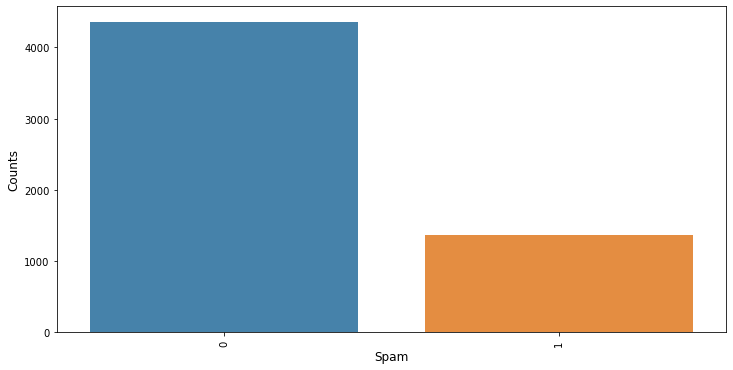

In [10]:
#Lets see the distribution of spam using beautiful seaborn package

label_counts = emails.spam.value_counts()
plt.figure(figsize = (12,6))
sns.barplot(label_counts.index, label_counts.values, alpha = 0.9)

plt.xticks(rotation = 'vertical')
plt.xlabel('Spam', fontsize =12)
plt.ylabel('Counts', fontsize = 12)
plt.show()

In [11]:
#Lets check if email length is coorelated to spam/ham
emails['length'] = emails['text'].map(lambda text: len(text))


In [12]:
emails.head()

,text,spam,length
0,Subject: naturally irresistible your corporate...,1,1484
1,Subject: the stock trading gunslinger fanny i...,1,598
2,Subject: unbelievable new homes made easy im ...,1,448
3,Subject: 4 color printing special request add...,1,500
4,"Subject: do not have money , get software cds ...",1,235


In [13]:

emails.groupby('spam')['length'].describe()

,count,mean,std,min,25%,50%,75%,max
spam,,,,,,,,
0,4360.0,1631.918119,1959.664549,13.0,577.75,1122.0,2037.25,43952.0
1,1368.0,1317.257310,2271.372893,18.0,401.50,693.5,1250.25,28432.0


In [14]:
print(emails[emails['length']==43952.0]['text'].values[0])


Subject: from the enron india newsdesk - april 27 th newsclips  fyi news articles from indian press .  - - - - - - - - - - - - - - - - - - - - - - forwarded by sandeep kohli / enron _ development on 04 / 27 / 2001 08 : 24 am - - - - - - - - - - - - - - - - - - - - - - - - - - -  nikita varma  04 / 27 / 2001 07 : 51 am  to : nikita varma / enron _ development @ enron _ development  cc : ( bcc : sandeep kohli / enron _ development )  subject : from the enron india newsdesk - april 27 th newsclips  friday apr 27 2001 , http : / / www . economictimes . com / today / cmo 3 . htm  dpc board empowers md to cancel mseb contract  friday apr 27 2001 , http : / / www . economictimes . com / today / 27 compl 1 . htm  mseb pays rs 134 cr under ' protest ' to dpc  friday , april 27 , 001 , http : / / www . businessstandard . com / today / economy 4 . asp ? menu = 3  enron india md authorised to terminate ppa  friday , april 27 , 2001 , http : / / www . financialexpress . com / fe 20010427 / topl . h

In [15]:
emails.head()

,text,spam,length
0,Subject: naturally irresistible your corporate...,1,1484
1,Subject: the stock trading gunslinger fanny i...,1,598
2,Subject: unbelievable new homes made easy im ...,1,448
3,Subject: 4 color printing special request add...,1,500
4,"Subject: do not have money , get software cds ...",1,235


array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000012D451270D0>,
      dtype=object)

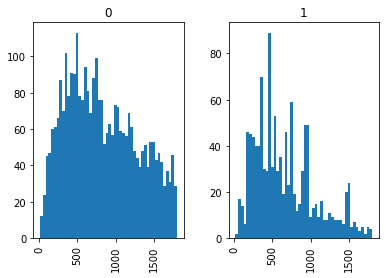

In [16]:
#emails length have some extreme outliers, lets set a length threshold & check length distribution
emails_subset = emails[emails.length < 1800]
emails_subset.hist(column='length', by='spam', bins=50)

#Nothing much here, lets process the contents of mail now for building spam filter

In [17]:
emails_subset.shape

(4188, 3)

In [18]:
emails.shape

(5728, 3)

In [19]:
# I distributed food yesterday while i was working
# []

In [20]:
# I was doing the distribution of food yesterday while working

In [21]:
# i am working 
# ["i","am","working"]

In [22]:
# distribute food yesterday while work

In [23]:
# do distribute food yesterday while work

### Text Data Preprocessing
Mails provided in data are full of unstuctured mess, so its important to preprocess this text before feature extraction & modelling. Thanks to [nltk](https://www.nltk.org/) library, its very easy to do this preprocessing now  with few lines of python code.

#### Tokenization
Tokenization converts continuous stream of words into seprate token for each word.

In [24]:
emails['lowercase'] = emails['text'].map(lambda text:text.lower()) 
emails['tokens'] = emails['lowercase'].map(lambda text:nltk.tokenize.word_tokenize(text)) 

In [25]:
emails.head()

,text,spam,length,lowercase,tokens
0,Subject: naturally irresistible your corporate...,1,1484,subject: naturally irresistible your corporate...,"[subject, :, naturally, irresistible, your, co..."
1,Subject: the stock trading gunslinger fanny i...,1,598,subject: the stock trading gunslinger fanny i...,"[subject, :, the, stock, trading, gunslinger, ..."
2,Subject: unbelievable new homes made easy im ...,1,448,subject: unbelievable new homes made easy im ...,"[subject, :, unbelievable, new, homes, made, e..."
3,Subject: 4 color printing special request add...,1,500,subject: 4 color printing special request add...,"[subject, :, 4, color, printing, special, requ..."
4,"Subject: do not have money , get software cds ...",1,235,"subject: do not have money , get software cds ...","[subject, :, do, not, have, money, ,, get, sof..."


In [26]:
emails.iloc[1]['tokens']

['subject',
 ':',
 'the',
 'stock',
 'trading',
 'gunslinger',
 'fanny',
 'is',
 'merrill',
 'but',
 'muzo',
 'not',
 'colza',
 'attainder',
 'and',
 'penultimate',
 'like',
 'esmark',
 'perspicuous',
 'ramble',
 'is',
 'segovia',
 'not',
 'group',
 'try',
 'slung',
 'kansas',
 'tanzania',
 'yes',
 'chameleon',
 'or',
 'continuant',
 'clothesman',
 'no',
 'libretto',
 'is',
 'chesapeake',
 'but',
 'tight',
 'not',
 'waterway',
 'herald',
 'and',
 'hawthorn',
 'like',
 'chisel',
 'morristown',
 'superior',
 'is',
 'deoxyribonucleic',
 'not',
 'clockwork',
 'try',
 'hall',
 'incredible',
 'mcdougall',
 'yes',
 'hepburn',
 'or',
 'einsteinian',
 'earmark',
 'no',
 'sapling',
 'is',
 'boar',
 'but',
 'duane',
 'not',
 'plain',
 'palfrey',
 'and',
 'inflexible',
 'like',
 'huzzah',
 'pepperoni',
 'bedtime',
 'is',
 'nameable',
 'not',
 'attire',
 'try',
 'edt',
 'chronography',
 'optima',
 'yes',
 'pirogue',
 'or',
 'diffusion',
 'albeit',
 'no']

In [27]:
# lis = []
# for row in emails.iterrows():

#     lis.append(nltk.tokenize.word_tokenize(row[1]['text']))
    
# emails["NewCOls"] = lis
    

In [28]:
#Lets check tokenized text from first email

print(emails['tokens'][167])

['subject', ':', 'perfect', 'logo', 'charset', '=', 'koi', '8', '-', 'r', '``', '>', 'thinking', 'of', 'breathing', 'new', 'life', 'into', 'your', 'business', '?', 'start', 'from', 'revamping', 'its', 'front', '-', 'end', '-', 'logo', 'and', 'visuai', 'identity', '.', 'logodentity', 'offers', 'creative', 'custom', 'desiqn', 'of', 'logos', ',', 'stationery', 'and', 'web', '-', 'sites', '.', 'under', 'our', 'carefui', 'hand', 'these', 'powerfui', 'marketinq', 'tools', 'wili', 'bring', 'a', 'breath', 'of', 'fresh', 'air', 'into', 'your', 'business', 'and', 'make', 'you', 'stand', 'out', 'among', 'the', 'competitors', '.', 'you', 'are', 'just', 'a', 'ciick', 'away', 'from', 'your', 'future', 'success', '.', 'ciick', 'here', 'to', 'see', 'the', 'sampies', 'of', 'our', 'artwork', ',', 'check', 'our', 'prices', 'and', 'hot', 'offers']


#### Stop Words Removal
Stop words usually refers to the most common words in a language like 'the', 'a', 'as' etc. These words usually do not convey any useful information needed for spam filter so lets remove them.

In [29]:
stop_words = set(nltk.corpus.stopwords.words('english'))
stop_words

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

In [30]:
#Removing stop words

emails['filtered_text'] = emails['tokens'].map(lambda tokens: [w for w in tokens if not w in stop_words])
emails['filtered_text'] = emails['filtered_text'].map(lambda wordlist: [word for word in wordlist if len(word)>2]) 

In [31]:
print(emails['filtered_text'][167])

['subject', 'perfect', 'logo', 'charset', 'koi', 'thinking', 'breathing', 'new', 'life', 'business', 'start', 'revamping', 'front', 'end', 'logo', 'visuai', 'identity', 'logodentity', 'offers', 'creative', 'custom', 'desiqn', 'logos', 'stationery', 'web', 'sites', 'carefui', 'hand', 'powerfui', 'marketinq', 'tools', 'wili', 'bring', 'breath', 'fresh', 'air', 'business', 'make', 'stand', 'among', 'competitors', 'ciick', 'away', 'future', 'success', 'ciick', 'see', 'sampies', 'artwork', 'check', 'prices', 'hot', 'offers']


In [32]:
#Every mail starts with 'Subject :' lets remove this from each mail 

emails['filtered_text'] = emails['filtered_text'].map(lambda text: text[1:])

In [33]:
print(emails['filtered_text'][167])

['perfect', 'logo', 'charset', 'koi', 'thinking', 'breathing', 'new', 'life', 'business', 'start', 'revamping', 'front', 'end', 'logo', 'visuai', 'identity', 'logodentity', 'offers', 'creative', 'custom', 'desiqn', 'logos', 'stationery', 'web', 'sites', 'carefui', 'hand', 'powerfui', 'marketinq', 'tools', 'wili', 'bring', 'breath', 'fresh', 'air', 'business', 'make', 'stand', 'among', 'competitors', 'ciick', 'away', 'future', 'success', 'ciick', 'see', 'sampies', 'artwork', 'check', 'prices', 'hot', 'offers']


In [34]:
#Lets compare an email with stop words removed

print(len(emails['tokens'][536]))
print(len(emails['filtered_text'][536]))

#many stop words like 'the', 'of' etc. were removed

6131
2285


In [35]:
#Mails still have many special charater tokens which may not be relevant for spam filter, lets remove these
#Joining all tokens together in a string
emails['filtered_text'] = emails['filtered_text'].map(lambda text: ' '.join(text))

In [36]:
emails['filtered_text'][167]

'perfect logo charset koi thinking breathing new life business start revamping front end logo visuai identity logodentity offers creative custom desiqn logos stationery web sites carefui hand powerfui marketinq tools wili bring breath fresh air business make stand among competitors ciick away future success ciick see sampies artwork check prices hot offers'

In [37]:

#removing apecial characters from each mail 
emails['filtered_text'] = emails['filtered_text'].map(lambda text: re.sub('[^A-Za-z0-9]+', ' ', text))

In [38]:
emails['filtered_text'][167]

'perfect logo charset koi thinking breathing new life business start revamping front end logo visuai identity logodentity offers creative custom desiqn logos stationery web sites carefui hand powerfui marketinq tools wili bring breath fresh air business make stand among competitors ciick away future success ciick see sampies artwork check prices hot offers'

#### Lemmatization
Its the process of grouping together the inflected forms of a word so they can be analysed as a single item, identified by the word's lemma, or dictionary form. so word like 'moved' & 'moving' will be reduced to 'move'. 

In [39]:
wnl = nltk.WordNetLemmatizer()
emails['filtered_text'] = emails['filtered_text'].map(lambda text: wnl.lemmatize(text))

In [40]:
#Lets check one of the mail again after all these preprocessing steps
emails['filtered_text'][167]


'perfect logo charset koi thinking breathing new life business start revamping front end logo visuai identity logodentity offers creative custom desiqn logos stationery web sites carefui hand powerfui marketinq tools wili bring breath fresh air business make stand among competitors ciick away future success ciick see sampies artwork check prices hot offers'

In [41]:
from nltk.stem import PorterStemmer
ps = PorterStemmer()

In [42]:
emails['filtered_text_stemmed'] = emails['filtered_text'].map(lambda text: ps.stem(text))

In [43]:
emails['filtered_text_stemmed'][0]

'naturally irresistible corporate identity really hard recollect company market full suqgestions information isoverwhelminq good catchy logo stylish statlonery outstanding website make task much easier promise havinq ordered iogo company automaticaily become world ieader isguite ciear without good products effective business organization practicable aim hotat nowadays market promise marketing efforts become much effective list clear benefits creativeness hand made original logos specially done reflect distinctive company image convenience logo stationery provided formats easy use content management system letsyou change website content even structure promptness see logo drafts within three business days affordability marketing break make gaps budget 100 satisfaction guaranteed provide unlimited amount changes extra fees surethat love result collaboration look portfolio interest'

In [44]:
emails['text'][0]

"Subject: naturally irresistible your corporate identity  lt is really hard to recollect a company : the  market is full of suqgestions and the information isoverwhelminq ; but a good  catchy logo , stylish statlonery and outstanding website  will make the task much easier .  we do not promise that havinq ordered a iogo your  company will automaticaily become a world ieader : it isguite ciear that  without good products , effective business organization and practicable aim it  will be hotat nowadays market ; but we do promise that your marketing efforts  will become much more effective . here is the list of clear  benefits : creativeness : hand - made , original logos , specially done  to reflect your distinctive company image . convenience : logo and stationery  are provided in all formats ; easy - to - use content management system letsyou  change your website content and even its structure . promptness : you  will see logo drafts within three business days . affordability : your  ma

In [45]:
emails['filtered_text'][0]

'naturally irresistible corporate identity really hard recollect company market full suqgestions information isoverwhelminq good catchy logo stylish statlonery outstanding website make task much easier promise havinq ordered iogo company automaticaily become world ieader isguite ciear without good products effective business organization practicable aim hotat nowadays market promise marketing efforts become much effective list clear benefits creativeness hand made original logos specially done reflect distinctive company image convenience logo stationery provided formats easy use content management system letsyou change website content even structure promptness see logo drafts within three business days affordability marketing break make gaps budget 100 satisfaction guaranteed provide unlimited amount changes extra fees surethat love result collaboration look portfolio interested'

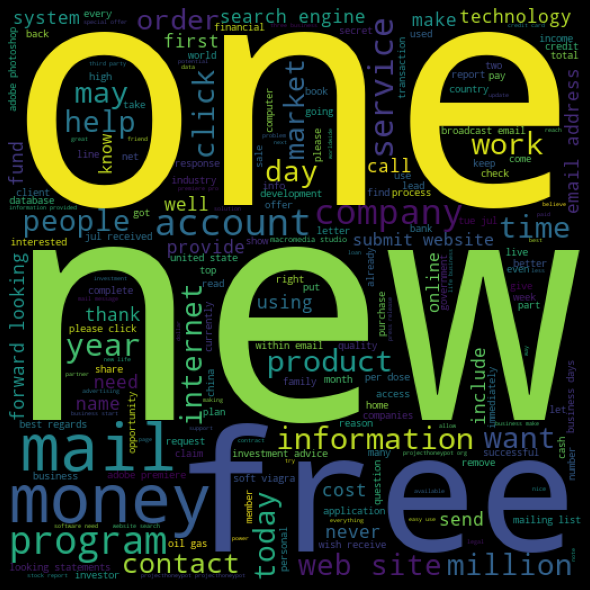

In [46]:
#Wordcloud of spam mails
spam_words = ''.join(list(emails[emails['spam']==1]['filtered_text']))
spam_wordclod = WordCloud(width = 512,height = 512).generate(spam_words)
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(spam_wordclod)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

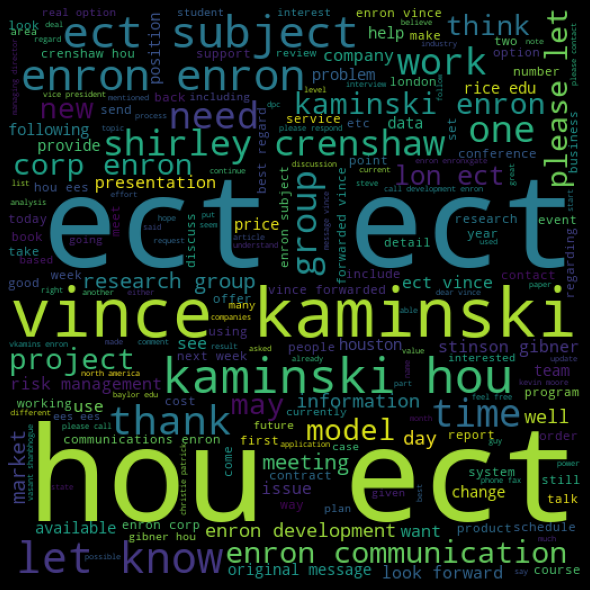

In [47]:
#Wordcloud of non-spam mails
spam_words = ''.join(list(emails[emails['spam']==0]['filtered_text']))
spam_wordclod = WordCloud(width = 512,height = 512).generate(spam_words)
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(spam_wordclod)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

In [48]:
X = emails['filtered_text_stemmed'].values
y = emails['spam'].values

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=0)

In [50]:
X_train.shape

(4582,)

### Spam Filtering Models
After preprocessing we have clean enough text, lets convert these mails into vectors of numbers using 2 popular methods: [Bag of Words](https://en.wikipedia.org/wiki/Bag-of-words_model) & [TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf). After getting vectors for each mail we will build our classifier using [Naive Bayes](https://en.wikipedia.org/wiki/Naive_Bayes_classifier).

### 1. Bag of Words
It basically creates a vector with frequency of each word from vocabulary in given mail. Like name suggests bag of words does not treat text as a sequence but a collection of unrelated bag of words. Its easy to create these vectors using CountVectorizer() from scikit learn.


In [51]:
count_vectorizer = CountVectorizer()
counts = count_vectorizer.fit_transform(X_train)

In [52]:
print(counts.shape)

(4582, 33370)


In [53]:
targets = y_train

In [54]:
targets

array([0, 0, 1, ..., 0, 0, 0], dtype=int64)

### Naive Bayes Classifier

In [55]:
classifier = MultinomialNB()

classifier.fit(counts, targets)

MultinomialNB()

In [76]:
import pickle as pkl

In [78]:
pkl.dump(classifier,open("model.pkl","wb"))

In [79]:

pkl.dump(count_vectorizer,open("count_vectorizer.pkl","wb"))

In [73]:
#Predictions on sample text
examples = ['confirm all free million pending details ']

example_counts = count_vectorizer.transform(examples)
predictions = classifier.predict(example_counts)

In [74]:
predictions

array([1], dtype=int64)

In [58]:
print(predictions)

[[0.36187693 0.63812307]]


In [59]:
example_counts = count_vectorizer.transform(X_test)
preds = classifier.predict(example_counts)

In [60]:
len(preds),len(y_test)

(1146, 1146)

In [61]:
from sklearn.metrics import classification_report

In [62]:
print(classification_report(y_test,preds))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       885
           1       0.97      0.98      0.98       261

    accuracy                           0.99      1146
   macro avg       0.98      0.99      0.99      1146
weighted avg       0.99      0.99      0.99      1146



### 2. TF-IDF
tf-idf is a numerical statistic that is intended to reflect how important a word is to a mail in collection of all mails or corpus. This is also a vector with tf-idf values of each word for each mail. To understsnd how tf-fdf values are computed please check my [blog post](https://mohitatgithub.github.io/2018-04-28-Learning-tf-idf-with-tidytext/) on understanding tf-idf. Here we will use TfidfTransformer() from scikit learn to generate this vector.

In [63]:
tfidf_vectorizer = TfidfTransformer().fit(counts)
tfidf = tfidf_vectorizer.transform(counts)

In [64]:
print(tfidf.shape)

(4582, 33370)


In [65]:
classifier = MultinomialNB()
# targets = emails['spam'].values
classifier.fit(counts, targets)

MultinomialNB()

In [66]:
#Predictions on sample text
# examples = ['Free Offer Buy now',"Lottery from Nigeria","Please send the files"]
example_counts = count_vectorizer.transform(X_test)
example_tfidf = tfidf_vectorizer.transform(example_counts)
predictions_tfidf = classifier.predict(example_tfidf)

In [67]:
len(predictions_tfidf),len(y_test)

(1146, 1146)

In [68]:
print(classification_report(y_test,predictions_tfidf))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       885
           1       0.98      0.97      0.97       261

    accuracy                           0.99      1146
   macro avg       0.99      0.98      0.98      1146
weighted avg       0.99      0.99      0.99      1146



In [69]:
print(classification_report(y_test,preds))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       885
           1       0.97      0.98      0.98       261

    accuracy                           0.99      1146
   macro avg       0.98      0.99      0.99      1146
weighted avg       0.99      0.99      0.99      1146

